# Task 2 - Transductive Learning

**Project Team 9**

*Cora* is a citation
graph connecting publications (the nodes) and their feature vectors (extracted from the publications). The task is to assign the publications to one of seven classes, when only observing the labels for a
subset of nodes (use the split=’public’ argument when loading the dataset).

## 2.0 Setup

Loading the Dataset
Installing Packages

In [ ]:
import random
import wandb
import matplotlib.colors as mcolors
import numpy as np
from tqdm import tqdm
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch_geometric
import torch_geometric.nn as pyg_nn
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.cm import ScalarMappable
import seaborn as sns
from functools import partial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, to_networkx



from random import randint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.1 Data Exploration

In [ ]:
dataset = Planetoid(name='Cora', root='data/CiteSeer')
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of features for each node: 1433
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True
Diamenter: 19
Statistics on node degree


count  mean    std  min  25%  50%   75%    max
0  2708.0   7.8  10.46  2.0  4.0  6.0  10.0  336.0

Statistics on non-zero features for each node


count   mean   std  min   25%   50%   75%   max
0  2708.0  18.17  5.76  1.0  17.0  20.0  22.0  30.0

Text(0.5, 1.0, 'Number of non-zero features for each node')

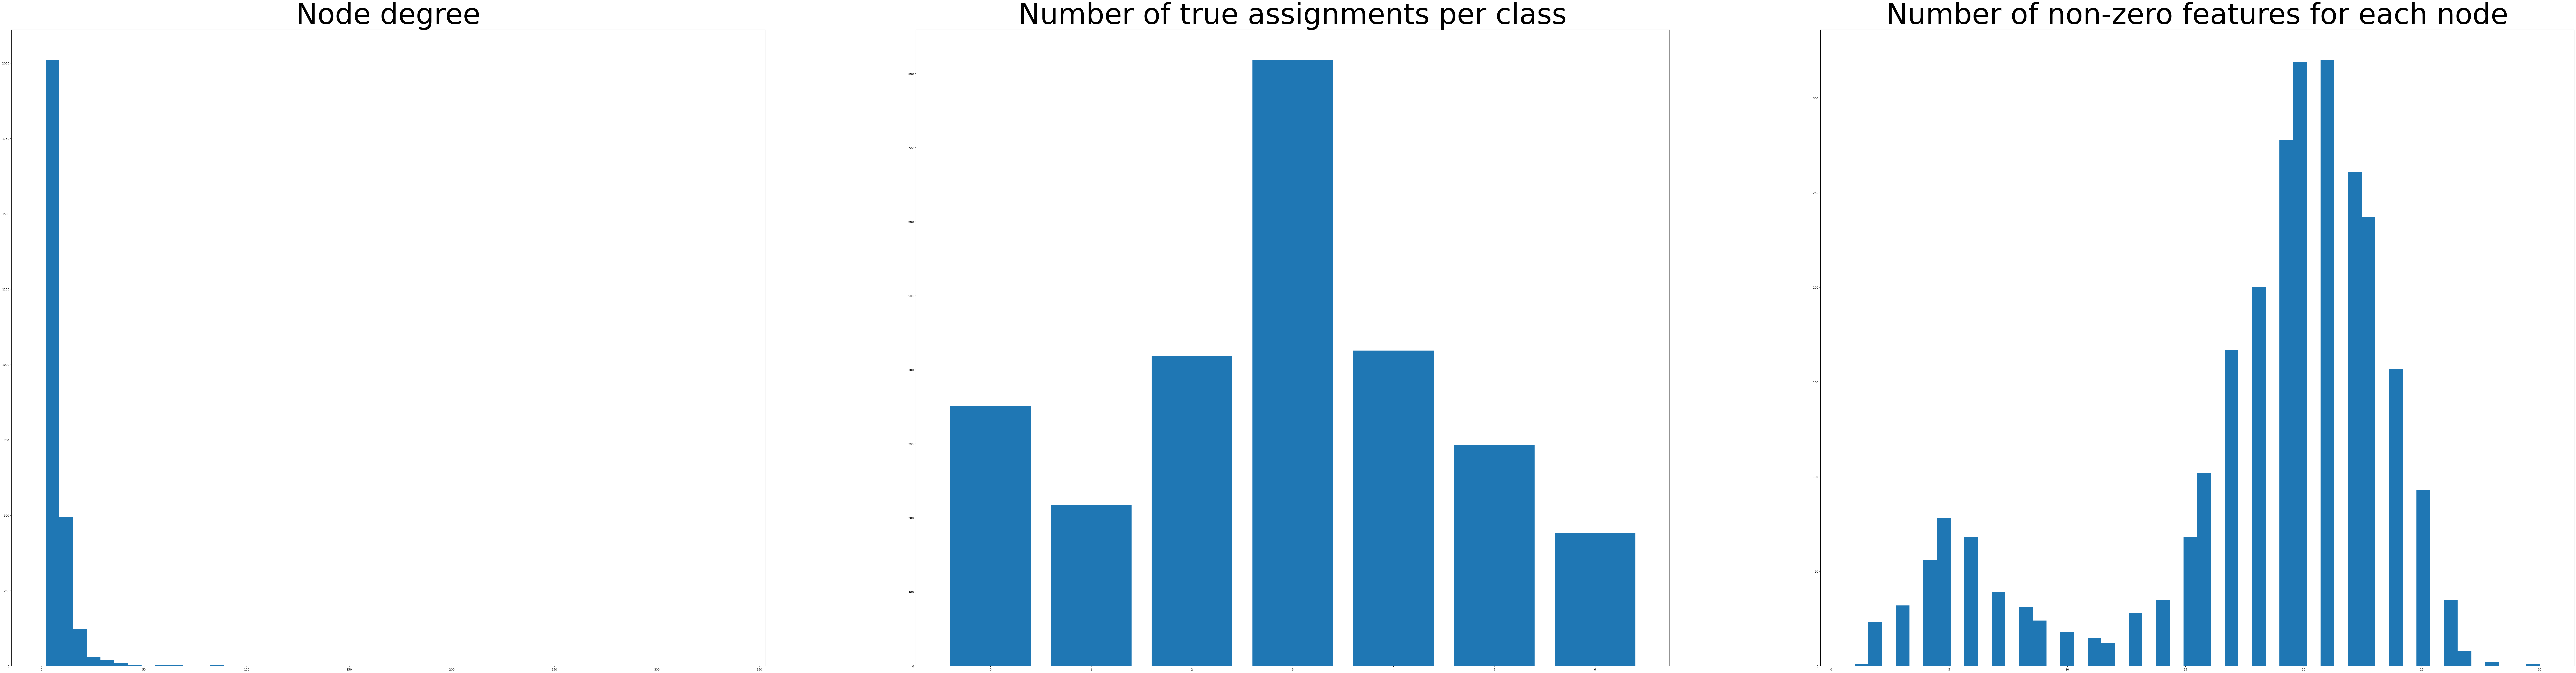

In [ ]:
data = dataset[0]  # Get the first (and only) graph object.
gx = to_networkx(data) #Networkx object
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features for each node: {dataset.num_node_features}') # Number of features for each node
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(gx)]) #List of shortest paths from i to j
print(f'Diamenter: {diameter}') # Max shortest path - graph diameter
print('======================')
print("Statistics on node degree")
degrees = [val for (node, val) in gx.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2)) # Summary statistics on node degrees


# Distribution of classes to investigate class imbalance
classes, counts = np.unique(dataset.y,return_counts=True)


# Compute the number of non-zero features for each node
print('======================')
print("Statistics on non-zero features for each node")
num_features_per_node = data.x.gt(0).sum(dim=1)
display(pd.DataFrame(pd.Series(num_features_per_node).describe()).transpose().round(2)) # Summary statistics on node degrees


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(160, 40))
axes[0].hist(degrees, bins=50)
axes[0].set_title("Node degree", size=100)
axes[1].bar(classes,counts)
axes[1].set_title("Number of true assignments per class", size=100)
axes[2].hist(num_features_per_node, bins=50)
axes[2].set_title("Number of non-zero features for each node", size=100)

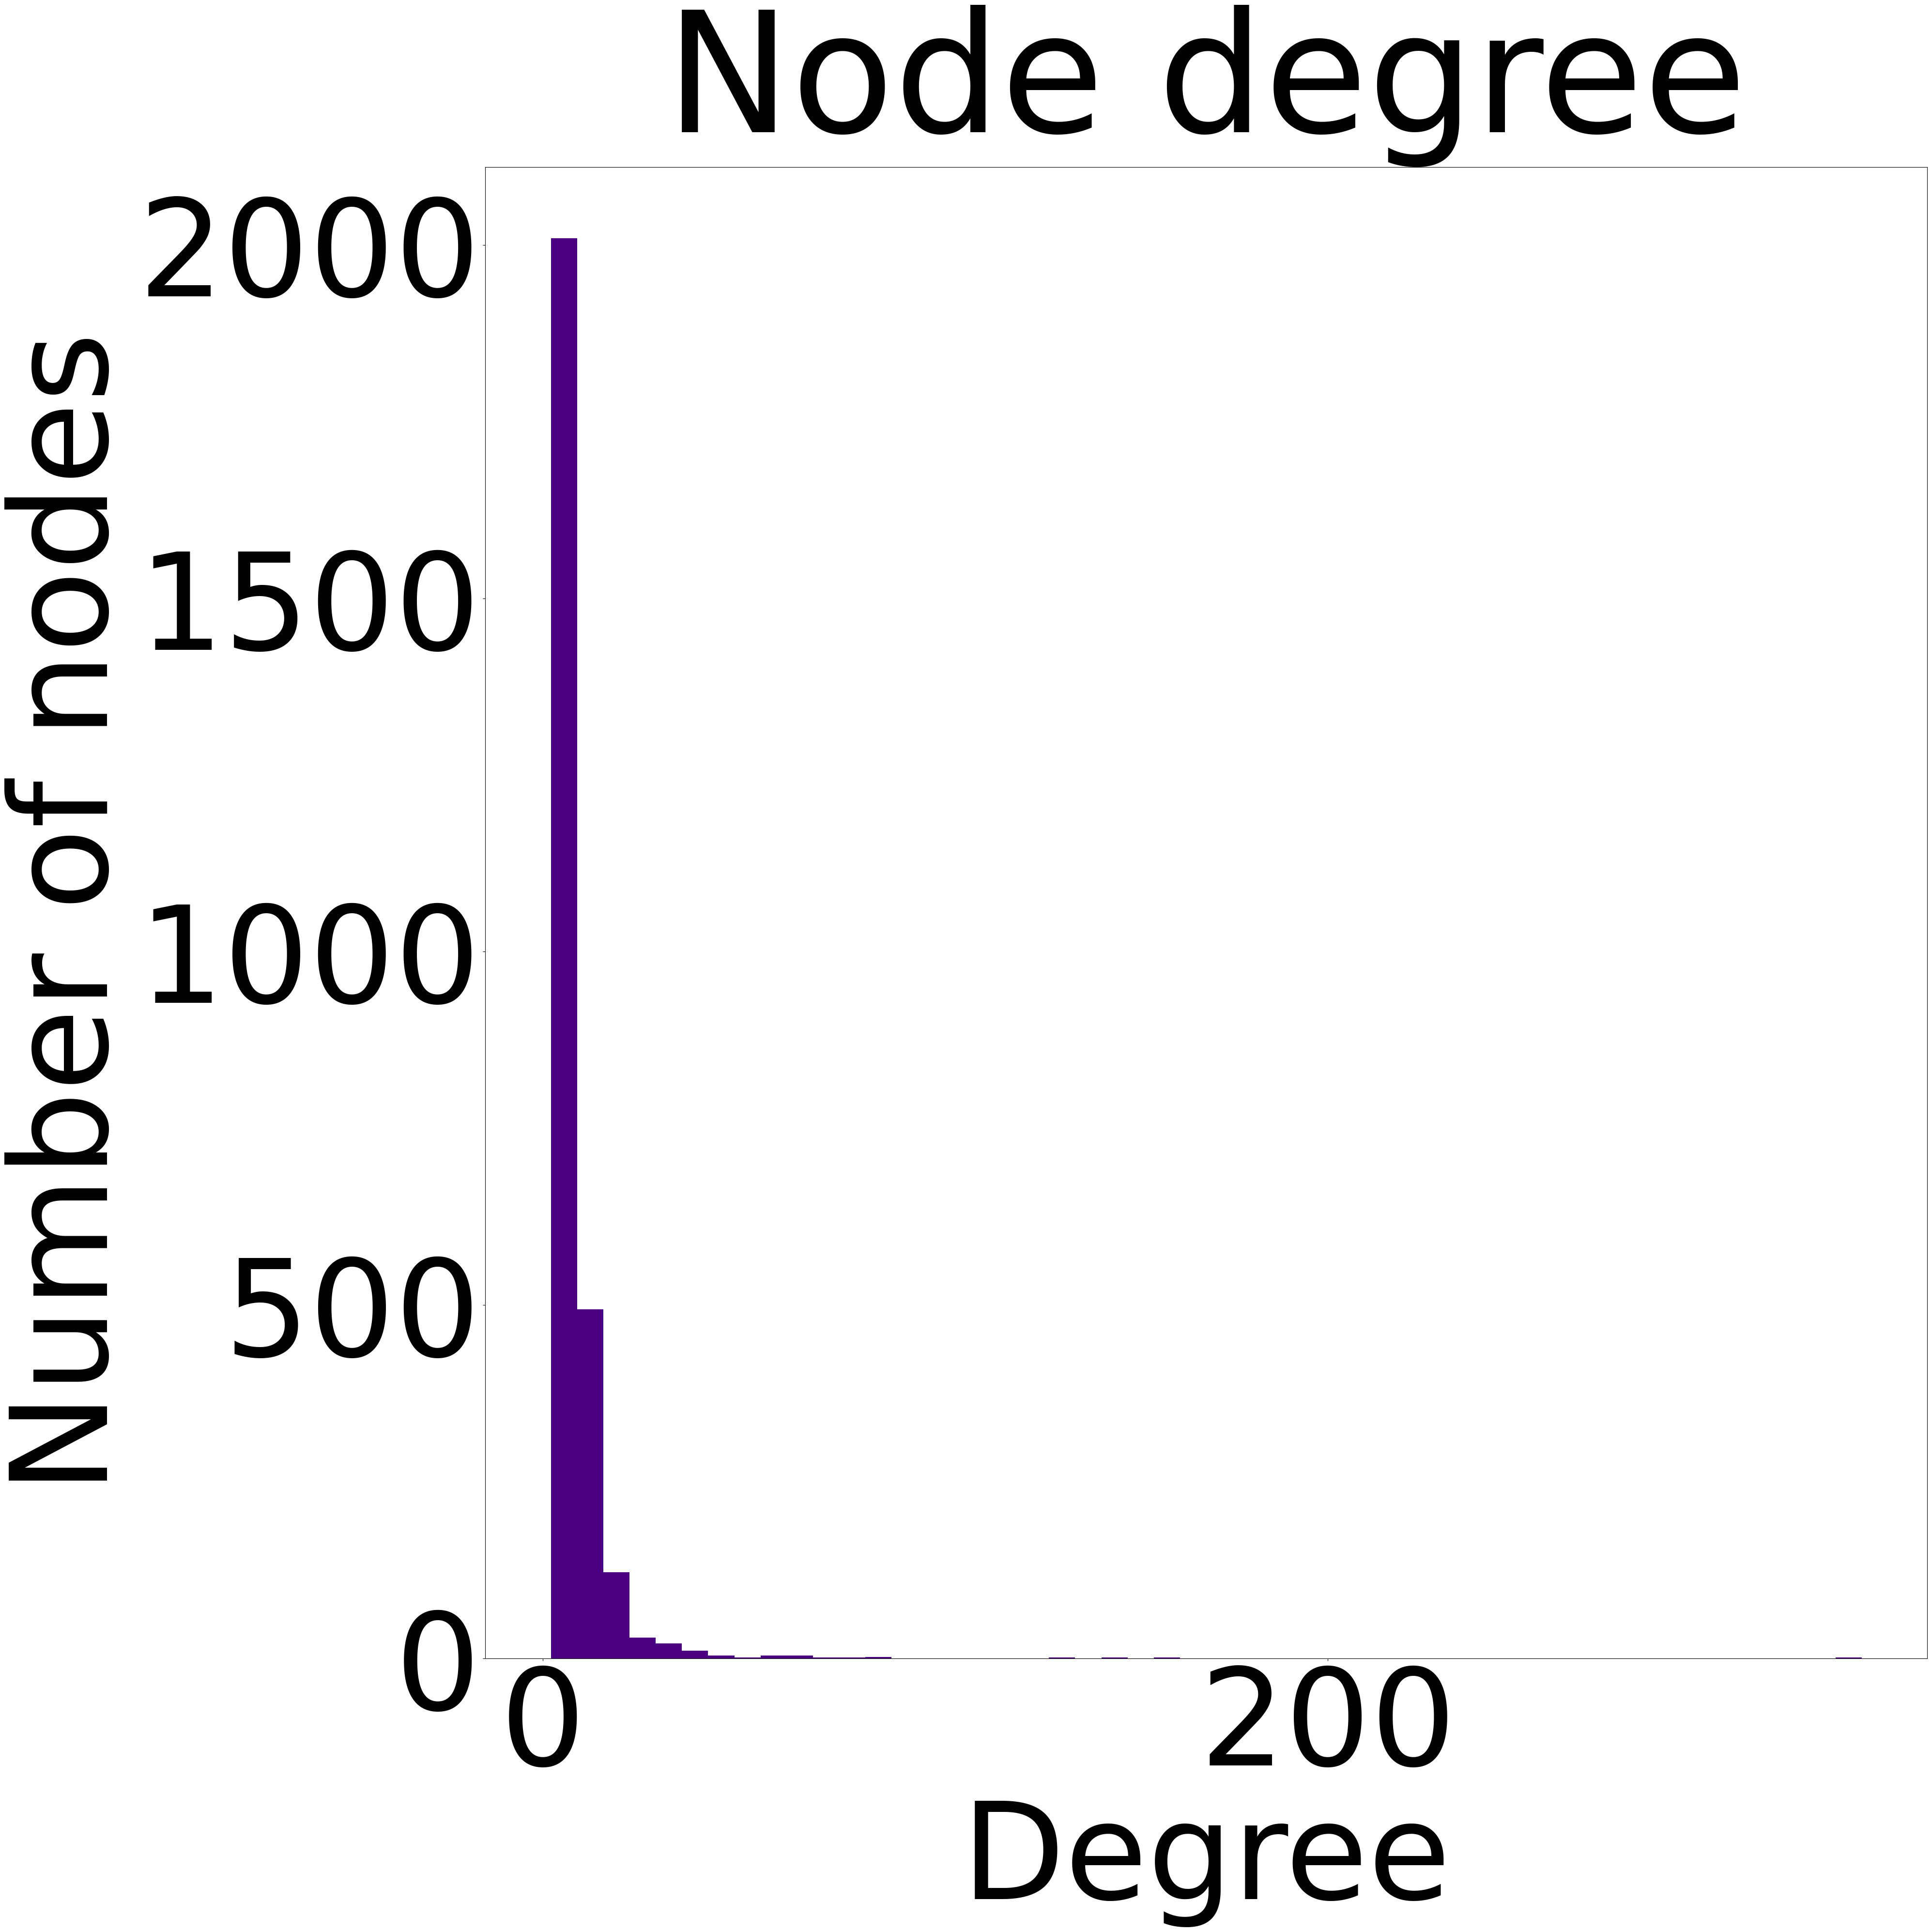

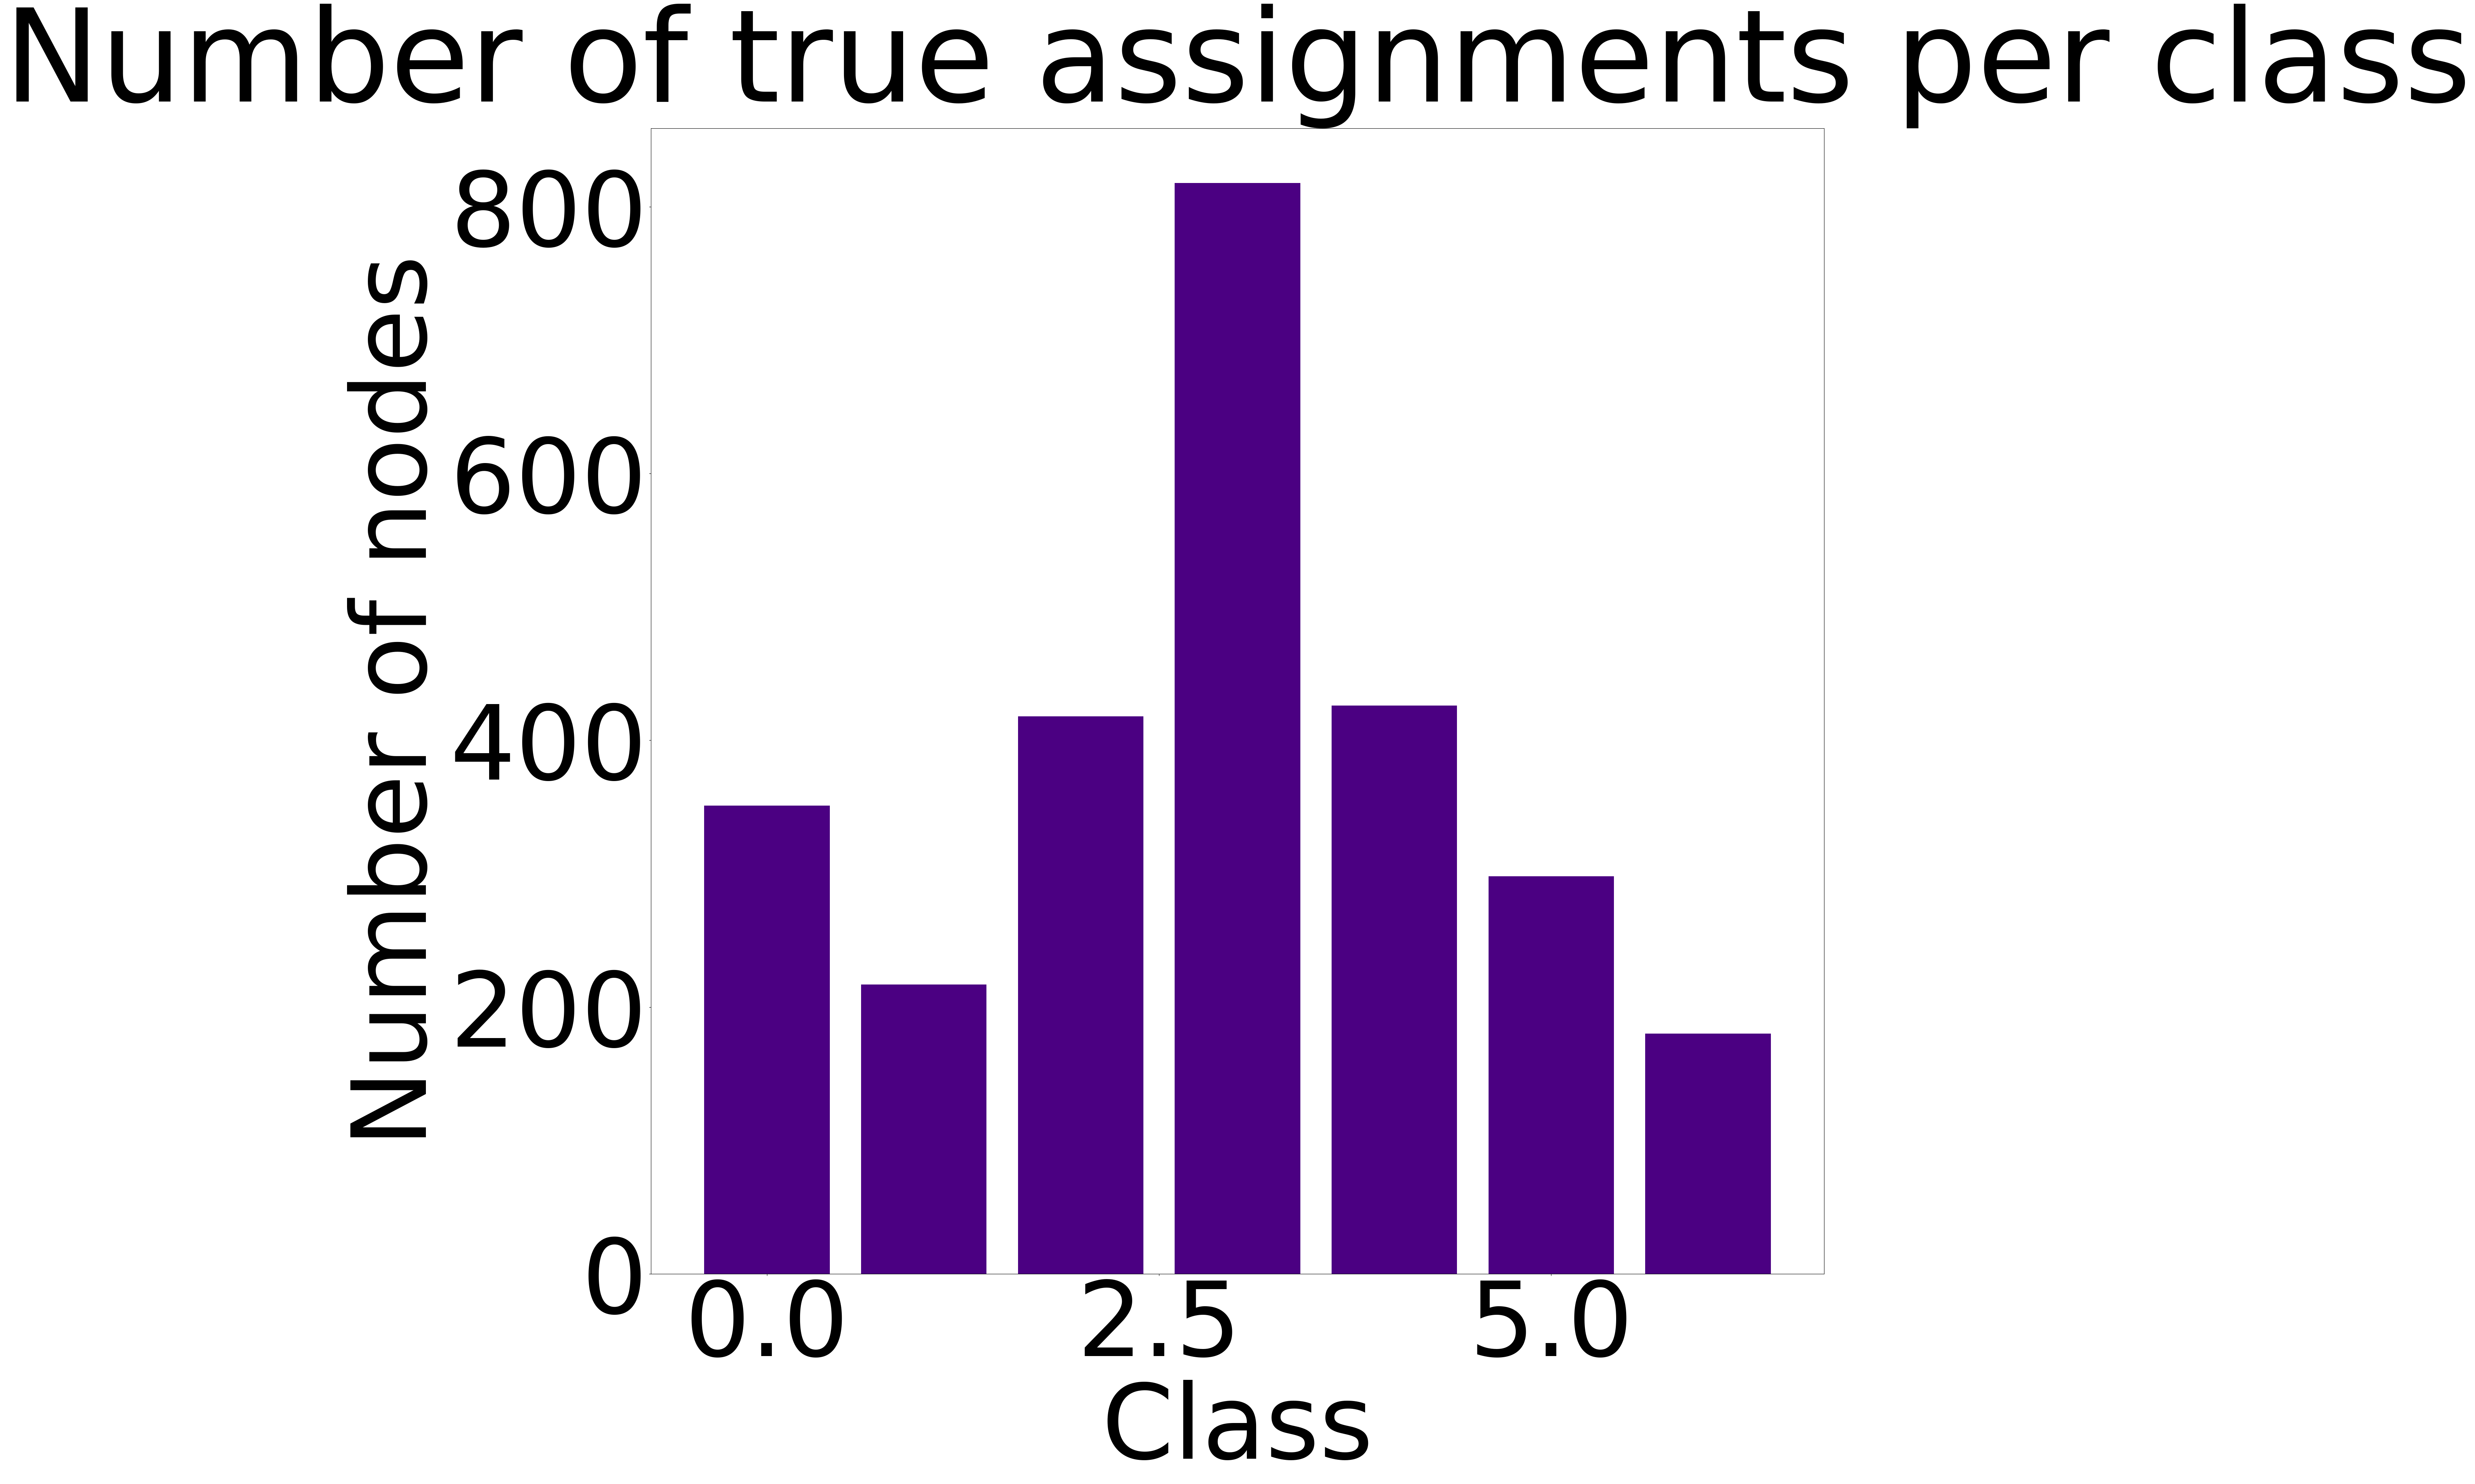

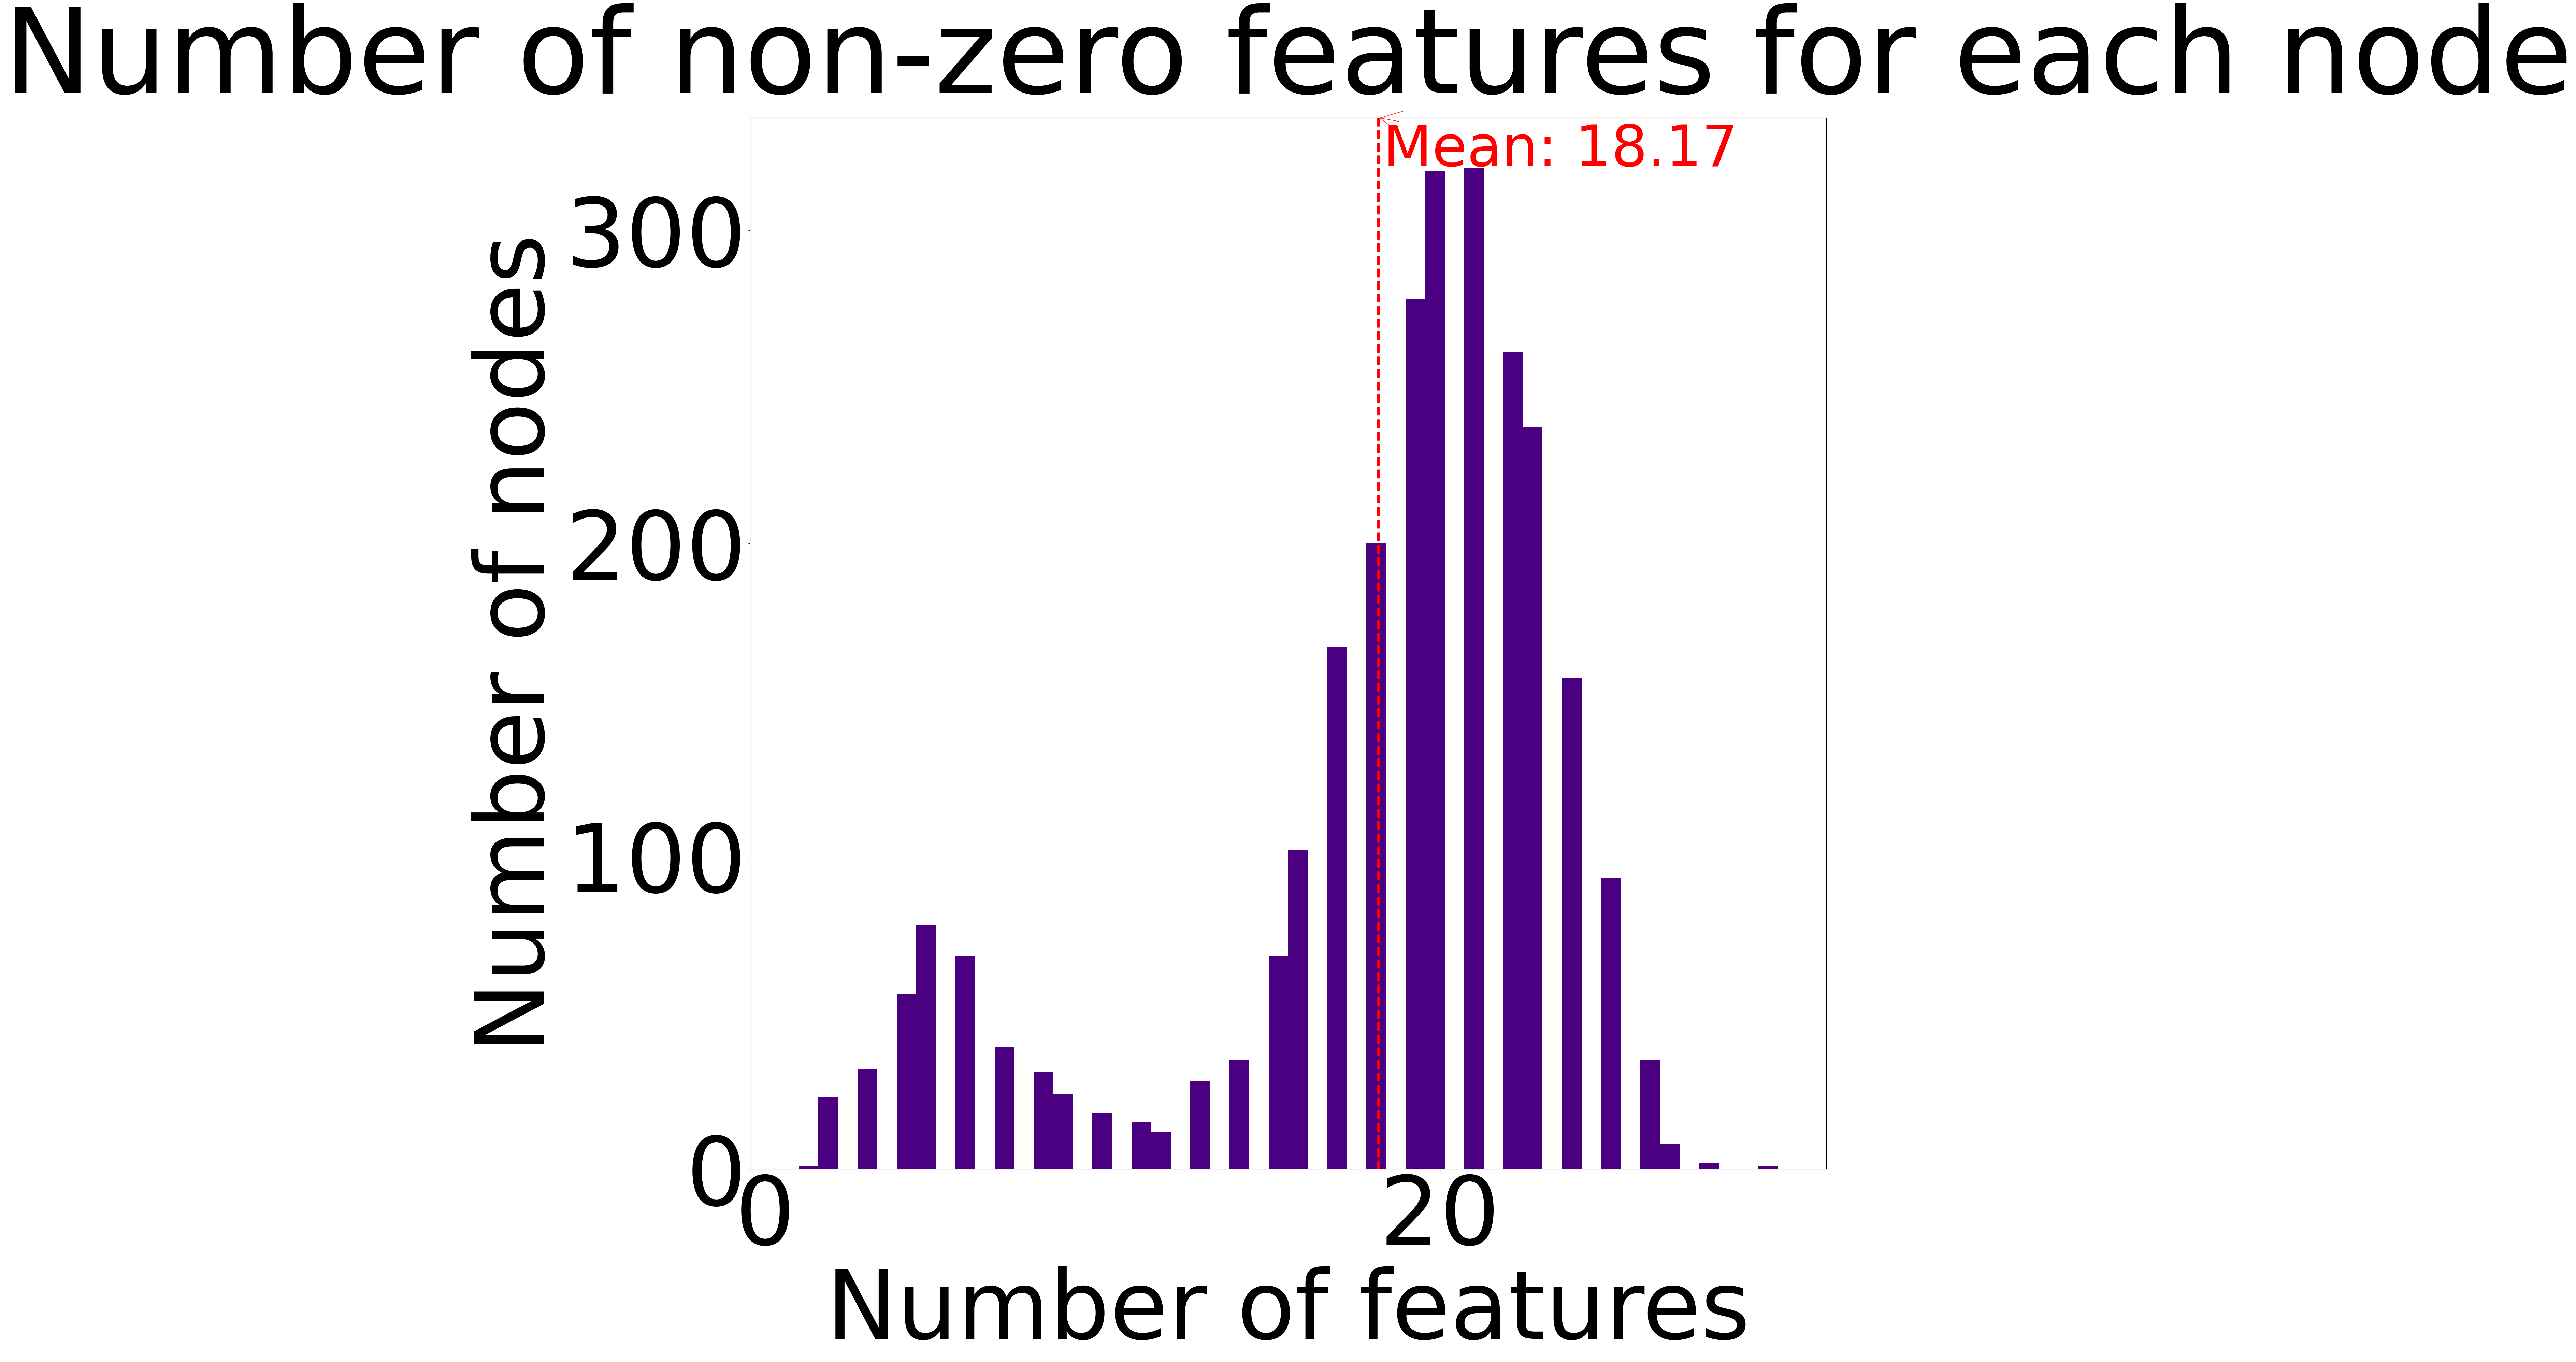

In [ ]:
### FOR THE REPORT ###

data = dataset[0]
gx = to_networkx(data)

# Reset to default plotting style
plt.rcdefaults()

# Explicitly turn off LaTeX rendering in Matplotlib
plt.rcParams['text.usetex'] = False
degrees = [val for (node, val) in gx.degree()]
classes, counts = np.unique(dataset.y, return_counts=True)
num_features_per_node = data.x.gt(0).sum(dim=1)

# Define a common style for the plots
dark_purple = '#4B0082'
plt.rcParams['axes.titlesize'] = 250
plt.rcParams['axes.labelsize'] = 200
plt.rcParams['xtick.labelsize'] = 200
plt.rcParams['ytick.labelsize'] = 200

# Histogram for node degree
fig1 = plt.figure(figsize=(40, 40))
plt.hist(degrees, bins=50, color=dark_purple)
plt.title("Node degree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.tight_layout()
plt.savefig("node_degree_histogram.png")  # Save the figure
plt.show()

# Bar chart for number of true assignments per class
fig2 = plt.figure(figsize=(40, 40))
plt.bar(classes, counts, color=dark_purple)
plt.title("Number of true assignments per class")
plt.xlabel("Class")
plt.ylabel("Number of nodes")
plt.tight_layout()
plt.savefig("class_assignments_bar_chart.png")  # Save the figure
plt.show()

# Histogram for number of non-zero features for each node
fig3 = plt.figure(figsize=(40, 40))
plt.hist(num_features_per_node, bins=50, color=dark_purple)

mean_val = num_features_per_node.float().mean().item()  # Compute the mean value
plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=5)  # Draw a vertical line at the mean
plt.annotate(f'Mean: {mean_val:.2f}',   # Annotate the mean value
             xy=(mean_val, plt.gca().get_ylim()[1]),  # Use the max y value to position at the top
             xycoords='data',
             xytext=(10, -10),  # Offset the text from the top left corner
             textcoords='offset points',
             color='red',
             fontsize=120,
             ha="left",  # Horizontal alignment is left
             va="top",  # Vertical alignment is top
             arrowprops=dict(arrowstyle="->", color='red'))

plt.title("Number of non-zero features for each node")
plt.xlabel("Number of features")
plt.ylabel("Number of nodes")
plt.tight_layout()
plt.savefig("non_zero_features_histogram.png")  # Save the figure
plt.show()

### 2.2 Label Propagation with full observations

observe all labels on full graph
for each node, perform classification by
- extracting all immediate neighbours
- predict majority label found in neighbourhood

specifically,
given a node i and with label y_i, and its direct neighbourhood N(i) (connected by exactly one edge), compute NN classifier on the graph

$y_i = Majority({y_j | j \in N(i)})$

- if there is a tie, choose from tied options uniformly at random
(compute several times with different random seeds and provide standard deviation, over three runs)
give classification accurarcy with standard deviation

In [ ]:
def label_propagation(data, seed=None):
    """
    Label propagation function.
    """
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Extract edge index for easy lookup
    edge_index = data.edge_index.numpy()

    # Extract true labels
    y_true = data.y.numpy()

    # Placeholder for predicted labels
    y_pred = np.zeros_like(y_true)

    # Iterate through all nodes
    for node in range(data.num_nodes):
        # Get neighbors
        neighbors = np.append(edge_index[1][edge_index[0] == node], edge_index[0][edge_index[1] == node])

        # Get labels of neighbors
        neighbor_labels = y_true[neighbors]

        # Count occurrences of each label among neighbors
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)

        # Determine majority label
        max_count = np.max(counts)
        majority_labels = unique_labels[counts == max_count]

        # If there's a tie, choose randomly among the majority labels
        chosen_label = np.random.choice(majority_labels)

        # Assign chosen label to node
        y_pred[node] = chosen_label

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return accuracy

# Run label propagation with three different seeds
seeds = [42, 2, 25]
accuracies = [label_propagation(data, seed=s) for s in seeds]

# Calculate mean and standard deviation
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean Accuracy: {mean_accuracy:.3f}")
print(f"Standard Deviation: {std_accuracy:.3f}")

Mean Accuracy: 0.864
Standard Deviation: 0.004


## 2.3 Baseline without Graph Structure

In [ ]:
# Extract features and labels for train, validation, and test sets
X_train = data.x[data.train_mask].numpy()
y_train = data.y[data.train_mask].numpy()

X_val = data.x[data.val_mask].numpy()
y_val = data.y[data.val_mask].numpy()

X_test = data.x[data.test_mask].numpy()
y_test = data.y[data.test_mask].numpy()


In [ ]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Create the base model
rf = RandomForestClassifier()

# Grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with best parameters on combined train + val data
X_combined = np.concatenate([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_combined, y_combined)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


RandomForestClassifier(min_samples_split=10)

In [ ]:
# Evaluate on test set
test_accuracy = accuracy_score(y_test, best_rf.predict(X_test))
print(f"Test Accuracy with best hyperparameters: {test_accuracy:.4f}")


Test Accuracy with best hyperparameters: 0.6800


In [ ]:
# Multiple Runs
accuracies = []
seeds = [42, 2, 25]
for seed in seeds:
    model_RFC = RandomForestClassifier(**best_params, random_state=seed)
    model_RFC.fit(X_combined, y_combined)
    accuracies.append(accuracy_score(y_test, model_RFC.predict(X_test)))

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

Mean Test Accuracy: 0.6867
Standard Deviation: 0.0054


## 2.4 Untrained GNNs

In [ ]:
class GNN_Embedder(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, dropout = 0.5):
        super(GNN_Embedder, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, hidden_channels)
        self.embed = nn.Linear(hidden_channels, input_dim)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x,edge_index)
        # Second Message Passing Layer
        return  self.embed(x)

class GNN_Classifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, num_classes, dropout = 0.5):
        super(GNN_Classifier, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.conv1 = pyg_nn.GCNConv(input_dim, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, num_classes)
        self.classifier = nn.Softmax(dim=1)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x,edge_index)
        # Second Message Passing Layer
        return  self.classifier(x)

In [ ]:
# Initialize GNN model
model_GNN = GNN_Embedder(dataset.num_features, hidden_channels=16)
out = model_GNN(data.x, data.edge_index)

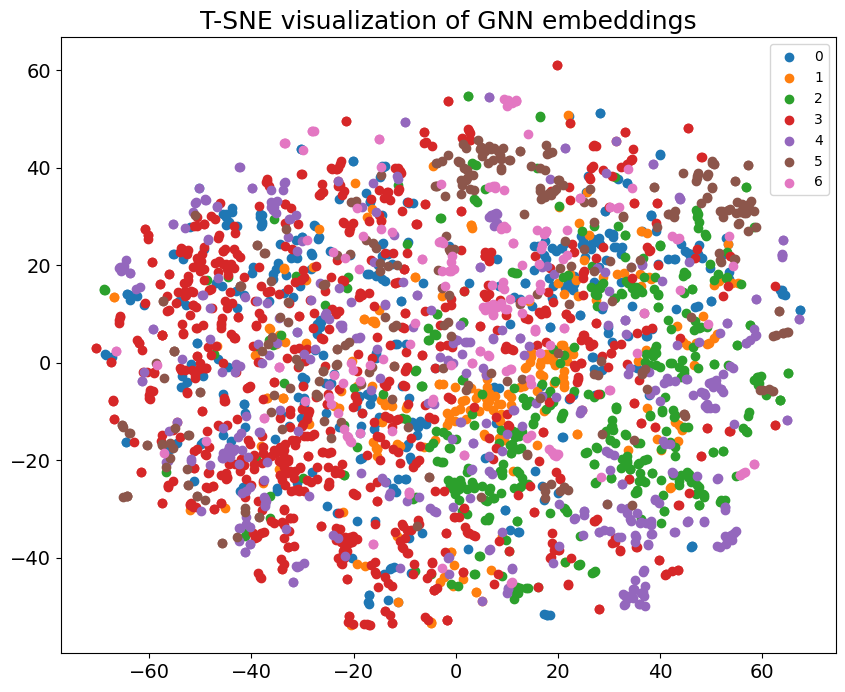

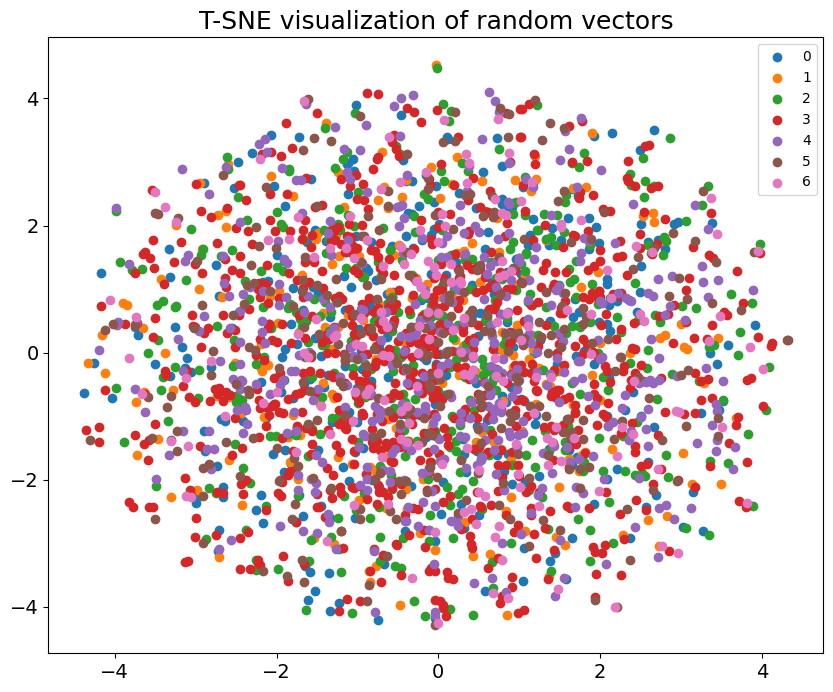

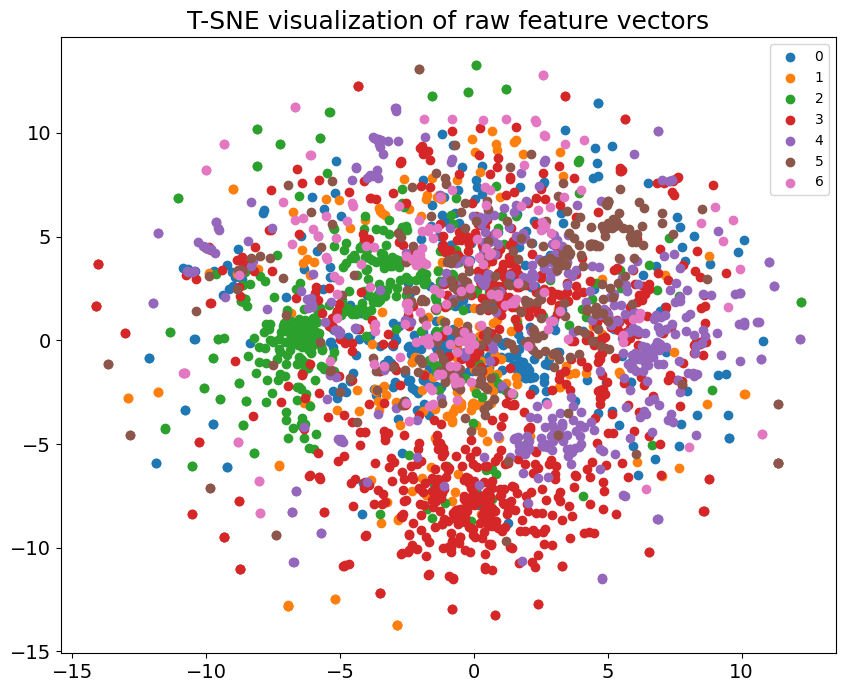

In [ ]:
# Compute embeddings for all nodes
with torch.no_grad():
    out = model_GNN(data.x, data.edge_index)
    embeddings = out.cpu().numpy()

# Visualize embeddings using T-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for i in range(dataset.num_classes):
    indices = data.y.cpu().numpy() == i
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=i)
plt.title('T-SNE visualization of GNN embeddings')
plt.legend()
plt.show()

# Generate and visualize random vectors
random_vectors = np.random.randn(*embeddings.shape)
random_vectors_2d = tsne.fit_transform(random_vectors)

plt.figure(figsize=(10, 8))
for i in range(dataset.num_classes):
    indices = data.y.cpu().numpy() == i
    plt.scatter(random_vectors_2d[indices, 0], random_vectors_2d[indices, 1], label=i)
plt.title('T-SNE visualization of random vectors')
plt.legend()
plt.show()

# Visualize raw feature vectors
raw_features_2d = tsne.fit_transform(data.x.cpu().numpy())

plt.figure(figsize=(10, 8))
for i in range(dataset.num_classes):
    indices = data.y.cpu().numpy() == i
    plt.scatter(raw_features_2d[indices, 0], raw_features_2d[indices, 1], label=i)
plt.title('T-SNE visualization of raw feature vectors')
plt.legend()
plt.show()

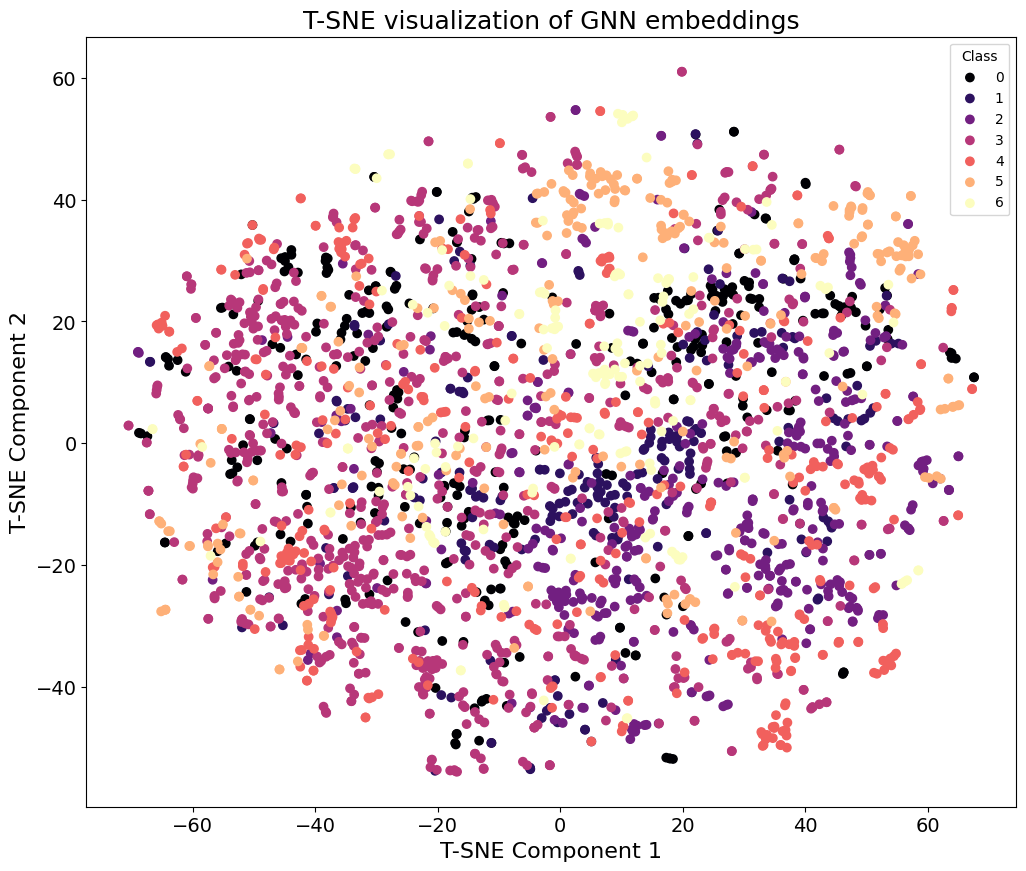

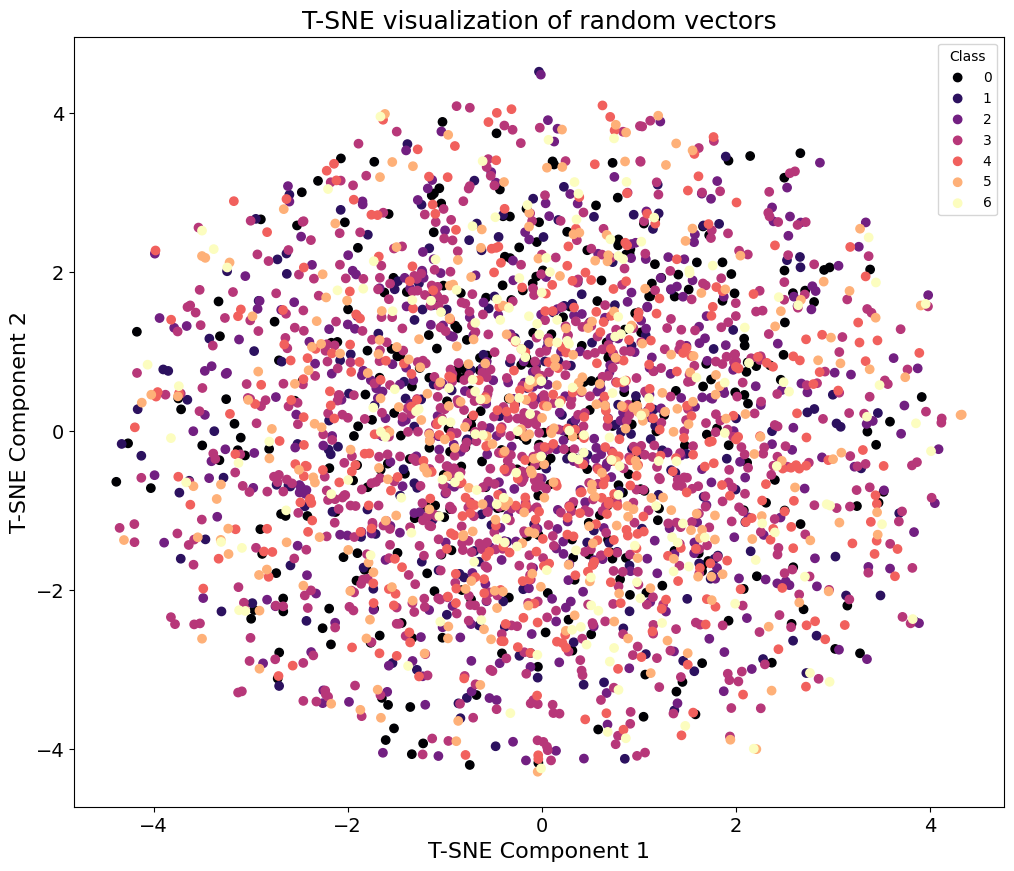

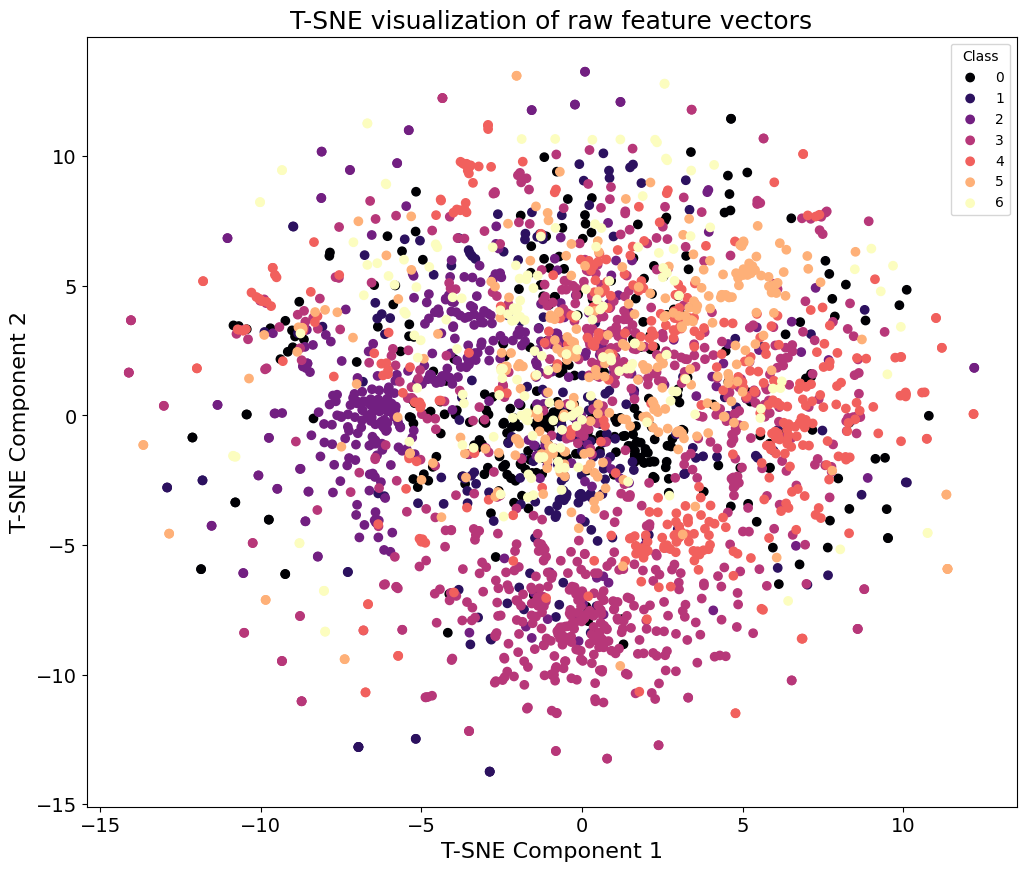

In [ ]:
### FOR THE REPORT ###

# Define a color map
cmap = plt.get_cmap('magma')

# Define a style for the plots
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Create a function for plotting to avoid repetition
def plot_2d_embeddings(embeddings_2d, labels, title, num_classes):
    norm = mcolors.Normalize(vmin=0, vmax=num_classes-1)
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        indices = labels == i
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                    c=[cmap(norm(i))]*sum(indices), label=i)
    plt.title(title)
    plt.xlabel('T-SNE Component 1')
    plt.ylabel('T-SNE Component 2')
    plt.legend(title='Class', loc='upper right')
    # plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='Class')
    plt.show()

# Compute and plot GNN embeddings
labels = data.y.cpu().numpy()
plot_2d_embeddings(embeddings_2d, labels, 'T-SNE visualization of GNN embeddings', dataset.num_classes)

# Compute and plot random vectors
plot_2d_embeddings(random_vectors_2d, labels, 'T-SNE visualization of random vectors', dataset.num_classes)

# Compute and plot raw feature vectors
plot_2d_embeddings(raw_features_2d, labels, 'T-SNE visualization of raw feature vectors', dataset.num_classes)


In [ ]:
def train_classifier_on_embeddings(embeddings, data, seed):
    # Train/test split
    X_train = embeddings[data.train_mask]
    y_train = data.y[data.train_mask].cpu().numpy()
    X_test = embeddings[data.test_mask]
    y_test = data.y[data.test_mask].cpu().numpy()

    # Train classifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=seed)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Compute accuracy
    return accuracy_score(y_test, y_pred)

seeds = [42, 2, 25]
acc_gnn_runs = []
acc_mlp_runs = []
acc_random_runs = []

for seed in seeds:
    # GNN embeddings
    acc_gnn_runs.append(train_classifier_on_embeddings(embeddings, data, seed))

    # Raw node features (using an untrained MLP to get embeddings)
    torch.manual_seed(seed)
    mlp = nn.Sequential(nn.Linear(dataset.num_features, 16), nn.ReLU(), nn.Linear(16, 16)).cpu()
    with torch.no_grad():
        mlp_embeddings = mlp(data.x.cpu()).numpy()
    acc_mlp_runs.append(train_classifier_on_embeddings(mlp_embeddings, data, seed))

    # Truly random embeddings
    acc_random_runs.append(train_classifier_on_embeddings(random_vectors, data, seed))

print(f"Mean Accuracy using GNN embeddings: {np.mean(acc_gnn_runs):.4f}, Std Dev: {np.std(acc_gnn_runs):.4f}")
print(f"Mean Accuracy using MLP embeddings: {np.mean(acc_mlp_runs):.4f}, Std Dev: {np.std(acc_mlp_runs):.4f}")
print(f"Mean Accuracy using random embeddings: {np.mean(acc_random_runs):.4f}, Std Dev: {np.std(acc_random_runs):.4f}")


Mean Accuracy using GNN embeddings: 0.4330, Std Dev: 0.0067
Mean Accuracy using MLP embeddings: 0.1943, Std Dev: 0.0180
Mean Accuracy using random embeddings: 0.1487, Std Dev: 0.0062


## 2.5 Trained GNN

In [ ]:
# Training function
torch.manual_seed(42)

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
    pred = logits[mask].argmax(dim=1)
    acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
    return acc

# Hyperparameters
hidden_channels = 30
lr = 0.1
epochs = 400

model_GNN_trained = GNN_Classifier(input_dim = dataset.num_features, hidden_channels=hidden_channels, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model_GNN_trained.parameters(), lr=lr, weight_decay=5e-3)
criterion = torch.nn.CrossEntropyLoss()


# Training loop
for epoch in range(epochs):
    loss = train(model_GNN_trained, data, optimizer, criterion)
    train_acc = evaluate(model_GNN_trained, data, data.train_mask)
    val_acc = evaluate(model_GNN_trained, data, data.val_mask)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
# Evaluation on the test set
test_acc = evaluate(model_GNN_trained, data, data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")



Epoch: 0, Loss: 1.9451, Train Acc: 0.4000, Val Acc: 0.1820
Epoch: 100, Loss: 1.2351, Train Acc: 1.0000, Val Acc: 0.7840
Epoch: 200, Loss: 1.2359, Train Acc: 1.0000, Val Acc: 0.7820
Epoch: 300, Loss: 1.2385, Train Acc: 1.0000, Val Acc: 0.7840
Test Accuracy: 0.7910


In [ ]:
# Multiple Runs
test_accuracies = []
seeds = [42, 24, 420]
for seed in seeds:
    torch.manual_seed(seed)
    model_GNN_trained = GNN_Classifier(input_dim = dataset.num_features, hidden_channels=hidden_channels, num_classes=dataset.num_classes).to(device)
    optimizer = optim.Adam(model_GNN_trained.parameters(), weight_decay=5e-3,lr=lr)
    for epoch in range(epochs):
        train(model_GNN_trained, data, optimizer, criterion)
    test_accuracies.append(evaluate(model_GNN_trained, data, data.test_mask))

mean_test_accuracy = np.mean(test_accuracies)

std_test_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_test_accuracy:.7f}")
print(f"Standard Deviation: {std_test_accuracy:.7f}")

Mean Test Accuracy: 0.8026667
Standard Deviation: 0.0084984


## 2.6 Visualizing Graph Attention Networks

In [ ]:
class GAT_Classifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, num_classes, dropout = 0.5):
        super(GAT_Classifier, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.conv1 = pyg_nn.GATConv(input_dim, hidden_channels)
        self.conv2 = pyg_nn.GATConv(hidden_channels, num_classes)
        self.classifier = nn.Softmax(dim=1)

    def forward(self, x, edge_index):
        # First Message Passing Layer
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x,edge_index)
        # Second Message Passing Layer
        x = self.drop(x)
        return  self.classifier(x)
        #x = x.relu()

In [ ]:
# Hyperparameters
hidden_channels = 40
lr = 0.0001
epochs = 600
torch.manual_seed(42)
model_GAT_trained = GAT_Classifier(input_dim = dataset.num_features, hidden_channels=hidden_channels, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model_GAT_trained.parameters(), lr=lr, eps = 1e-5, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


# Training loop
for epoch in range(epochs):
    model_GAT_trained.train()
    optimizer.zero_grad()
    out = model_GAT_trained(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_acc = evaluate(model_GAT_trained, data, data.train_mask)
    val_acc = evaluate(model_GAT_trained, data, data.val_mask)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Evaluation on the test set
test_acc = evaluate(model_GAT_trained, data, data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch: 0, Loss: 1.9450, Train Acc: 0.1357, Val Acc: 0.1560
Epoch: 100, Loss: 1.9027, Train Acc: 0.6643, Val Acc: 0.4820
Epoch: 200, Loss: 1.8043, Train Acc: 0.8357, Val Acc: 0.6440
Epoch: 300, Loss: 1.6993, Train Acc: 0.9571, Val Acc: 0.7540
Epoch: 400, Loss: 1.5980, Train Acc: 0.9857, Val Acc: 0.7860
Epoch: 500, Loss: 1.5574, Train Acc: 0.9929, Val Acc: 0.7960
Test Accuracy: 0.8070


In [ ]:
# Multiple Runs
test_accuracies = []
seeds = [42, 4242, 424242]
for seed in seeds:
    torch.manual_seed(seed)
    model_GAT_trained = GAT_Classifier(input_dim = dataset.num_features, hidden_channels=hidden_channels, num_classes=dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model_GAT_trained.parameters(), lr=lr, eps = 1e-6, weight_decay=5e-4)
    for epoch in range(epochs):
        train(model_GAT_trained, data, optimizer, criterion)
    test_accuracies.append(evaluate(model_GAT_trained, data, data.test_mask))

mean_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_test_accuracy:.7f}")
print(f"Std Test Accuracy: {std_test_accuracy:.7f}")

Mean Test Accuracy: 0.7830000
Std Test Accuracy: 0.0123558


<ipython-input-35-c8ef17fe3434>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = plt.cm.get_cmap('Greens')
<ipython-input-35-c8ef17fe3434>:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


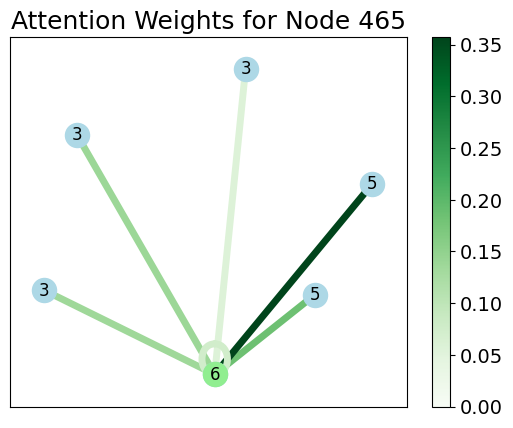

In [ ]:
# Forward pass with return_attention_weights=True
model_GAT_trained.eval()
with torch.no_grad():
    out, attn_weights = model_GAT_trained.conv1(data.x, data.edge_index, return_attention_weights=True)
    # Get the edge indices and attention weights
    edge_index_attn = attn_weights[0].cpu().numpy()
    attention_weights = attn_weights[1].cpu().numpy()

edges_from_sample = np.where(edge_index_attn[0] == 0)[0]

while len(edges_from_sample) < 5: #Find an interesting sample to visualise
    # Sample a node from the test set
    test_nodes = np.where(data.test_mask.cpu().numpy())[0]
    sample_node = randint(0,len(test_nodes))
    # Extracting edges that emanate from the sampled node
    edges_from_sample = np.where(edge_index_attn[0] == sample_node)[0]

# Extract the corresponding neighbors and attention weights
neighbors = edge_index_attn[1][edges_from_sample]
neighbor_weights = attention_weights[edges_from_sample]

#Visualisation
G = nx.Graph()
for neighbor in neighbors:
    G.add_node(neighbor, label=data.y[neighbor].item())
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_nodes(G, pos, node_color='lightblue')
nx.draw_networkx_nodes(G, pos, nodelist=[sample_node], node_color='lightgreen')
nx.draw_networkx_labels(G, pos, labels, font_size=12)
for i, weight in enumerate(neighbor_weights):
    G.add_edge(sample_node, neighbors[i], weight=weight)
edge_weights = nx.get_edge_attributes(G, 'weight')
flat_weights = neighbor_weights.flatten()
weights_normalized = [x / max(flat_weights) for x in flat_weights]
edge_weight_map = dict(zip([tuple(e) for e in G.edges()],weights_normalized))
my_cmap = plt.cm.get_cmap('Greens')
colors = my_cmap([edge_weight_map.get(tuple(e), 0) for e in G.edges()])
nx.draw_networkx_edges(G, pos, edge_color=colors,
                       edgelist=[tuple(e) for e in G.edges()],
                       width=5);
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(flat_weights)))
plt.title(f"Attention Weights for Node {sample_node}")
plt.colorbar(sm)


